# Hybrid quantum-classical feed forward neural network for solving the TSP.

In [ ]:
# !pip install -r requirements.txt

In [1]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import numpy as np
import sympy
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

2022-07-13 10:03:06.924146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 10:03:07.056592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 10:03:07.057595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 10:03:07.060230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## TSP 


In [2]:
class TSP:
    def __init__(self, number_of_cities, coords_range=(0, 10000)):
        self.number_of_cities = number_of_cities
        self.coords_range = coords_range
        self.cities_coords = self.get_cities()
        self.distance_matrix = self.calculate_distance_matrix()
        self.normalized_distance_matrix = self.normalize_distance_matrix()
    
    def get_cities(self):
        cities_coords = np.random.randint(self.coords_range[0], self.coords_range[1], size = (self.number_of_cities, 2))
        return cities_coords
           
    def normalize_cities(self):
        max_coords = np.amax(self.cities_coords, axis=0)
        normalized_cities_coords = np.divide(self.cities_coords, max_coords)
        return normalized_cities_coords

    def calculate_distance_between_points(self, point_A, point_B):
        return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)
    
    def calculate_distance_matrix(self):
        distance_matrix = np.zeros((self.number_of_cities, self.number_of_cities))
        for i in range(self.number_of_cities):
            for j in range(i, self.number_of_cities):
                distance_matrix[i][j] = self.calculate_distance_between_points(self.cities_coords[i], self.cities_coords[j])
                distance_matrix[j][i] = distance_matrix[i][j]
        return distance_matrix 
    
    def normalize_distance_matrix(self):
        return np.divide(self.distance_matrix, np.max(self.distance_matrix))

##  QAOA

In [3]:
class QAOA_TSP:
    def __init__(self, tsp_instance, p=1, A_1=4, A_2=4, B=1):
        self.tsp_instance = tsp_instance
        self.qubits = cirq.GridQubit.rect(1, tsp_instance.number_of_cities**2)
        self.p = p
        self.weights = {'cost_weight': B, 
                        'constraint_each_visited': A_1, 
                        'constraint_each_visited_once': A_2}
        self.parameters = self.generate_sympy_parameters()
        self.cost_operator = self.create_cost_operator()
        self.circuit = self.create_qaoa_circuit()
    
    def calc_bit(self, i, t):
        return i + t * self.tsp_instance.number_of_cities
    
    def x(self, i, t):
        x = self.calc_bit(i, t)
        qubit = self.qubits[x]
        return cirq.PauliString(0.5, cirq.I(qubit)) - cirq.PauliString(0.5, cirq.Z(qubit))
        
    def create_hadamard_circuit_layer(self):
        hadamard_circuit_layer = cirq.Circuit()
        for qubit in self.qubits:
            hadamard_circuit_layer += cirq.H(qubit)
        return hadamard_circuit_layer
    
    def generate_sympy_parameters(self):
        return sympy.symbols('parameter_:%d'%(2*self.p))

    def create_cost_operator(self):
        A_1 = self.weights['constraint_each_visited']
        A_2 = self.weights['constraint_each_visited_once']
        B = self.weights['cost_weight']
        
        cost_of_constraint_each_visited = 0    
        for i in range(self.tsp_instance.number_of_cities):
            curr = 1
            for t in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)    
            cost_of_constraint_each_visited += np.power(curr, 2)
            
        cost_of_constraint_each_visited_once = 0
        for t in range(self.tsp_instance.number_of_cities):
            curr = 1
            for i in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)
            cost_of_constraint_each_visited_once += np.power(curr, 2)
        
        cost_of_visiting_cities = 0
        for i, j in itertools.permutations(range(0, self.tsp_instance.number_of_cities), 2):
            curr = 0
            for t in range(self.tsp_instance.number_of_cities):
                inc_t = t + 1
                if inc_t == self.tsp_instance.number_of_cities:
                    inc_t = 0
                curr += self.x(i, t) * self.x(j, inc_t)
            cost_of_visiting_cities += self.tsp_instance.normalized_distance_matrix[i][j] * curr 
        
        cost_operator = A_1 * cost_of_constraint_each_visited + \
                        A_2 * cost_of_constraint_each_visited_once + \
                        B * cost_of_visiting_cities
                
        return cost_operator
    
    def create_mixing_operator(self):
        mixing_operator = 0
        for qubit in self.qubits:
            mixing_operator += cirq.X(qubit)
        return mixing_operator

    def create_qaoa_circuit(self):
        hadamard_circuit_layer = self.create_hadamard_circuit_layer()
        cost_operator = self.create_cost_operator()
        mixing_operator = self.create_mixing_operator()
        parameterized_circuit_layers = tfq.util.exponential(operators = [cost_operator, mixing_operator] * self.p, 
                                                            coefficients = self.parameters)
        qaoa_circuit = hadamard_circuit_layer + parameterized_circuit_layers
        return qaoa_circuit

In [4]:
tsp_instance = TSP(4)
qaoa_tsp = QAOA_TSP(tsp_instance, p=10, A_1=4, A_2=4, B=1)

Display the circuit (sometimes it takes a little while...).

In [5]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(qaoa_tsp.circuit)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


## Hybrid Quantum-Classical Feed Forward Neural Network

In [6]:
class QFFNN(tf.keras.layers.Layer):
  def __init__(self, parameters):
    super(QFFNN, self).__init__()
    self.parameters = parameters
    self.params_inp = tf.keras.Input(shape=(len(self.parameters),), name='input_layer')
    self.first_hidden = tf.keras.layers.Dense(len(self.parameters), name="hidden_layer")
    self.expectation = tfq.layers.Expectation(name="expectation_layer")
    

  def call(self, inputs):
    parameterized_circuit = inputs[0]
    cost_operator = inputs[1]
    initial_parameter_values = inputs[2]
    
    parameter_values = self.first_hidden(initial_parameter_values)
    expectation_value = self.expectation(parameterized_circuit,
                                       operators=cost_operator,
                                       symbol_names=self.parameters,
                                       symbol_values=parameter_values)

    return [parameter_values, expectation_value]

In [7]:
parametrized_circuit_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
operator_input = tf.keras.Input(shape=(1,), dtype=tf.dtypes.string)
parameters_input = tf.keras.Input(shape=(2 * qaoa_tsp.p,))

In [8]:
qffnn = QFFNN(qaoa_tsp.parameters)
output = qffnn([parametrized_circuit_input, operator_input, parameters_input])

In [9]:
model = tf.keras.Model(
              inputs=[
                  parametrized_circuit_input, 
                  operator_input, 
                  parameters_input
              ],
              outputs=[
                  output[0], # array of optimized 2p parameters
                  output[1], # expectation value
              ])

In [10]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss = tf.keras.losses.mean_absolute_error,
              loss_weights=[0, 1]
             )

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 qffnn (QFFNN)                  [(None, 20),         420         ['input_1[0][0]',                
                                 (None, 1)]                       'input_2[0][0]',            

In [12]:
circuit_tensor = tfq.convert_to_tensor([qaoa_tsp.circuit])
cost_operator_tensor = tfq.convert_to_tensor([qaoa_tsp.cost_operator])
initial_parameters = np.zeros((1, qaoa_tsp.p * 2)).astype(np.float32)

In [13]:
%%time
history = model.fit(
              x=[
                  circuit_tensor, 
                  cost_operator_tensor, 
                  initial_parameters, 
              ],
              y=[
                  np.zeros((1, qaoa_tsp.p * 2)),
                  np.zeros((1, 1)), # the closer to 0 the better the result
              ], 
              epochs=250,
              verbose=1)

Epoch 1/250
1/1 [==============================] - 9s 9s/step - loss: 72.5162 - qffnn_loss: 0.0000e+00 - qffnn_1_loss: 72.5162
Epoch 2/250
1/1 [==============================] - 1s 786ms/step - loss: 55.0093 - qffnn_loss: 0.0100 - qffnn_1_loss: 55.0093
Epoch 3/250
1/1 [==============================] - 1s 766ms/step - loss: 40.7010 - qffnn_loss: 0.0114 - qffnn_1_loss: 40.7010
Epoch 4/250
1/1 [==============================] - 1s 784ms/step - loss: 28.7976 - qffnn_loss: 0.0167 - qffnn_1_loss: 28.7976
Epoch 5/250
1/1 [==============================] - 1s 783ms/step - loss: 21.1155 - qffnn_loss: 0.0219 - qffnn_1_loss: 21.1155
Epoch 6/250
1/1 [==============================] - 1s 779ms/step - loss: 18.7426 - qffnn_loss: 0.0272 - qffnn_1_loss: 18.7426
Epoch 7/250
1/1 [==============================] - 1s 802ms/step - loss: 18.8190 - qffnn_loss: 0.0315 - qffnn_1_loss: 18.8190
Epoch 8/250
1/1 [==============================] - 1s 775ms/step - loss: 20.5510 - qffnn_loss: 0.0348 - qffnn_1_loss:

Epoch 66/250
1/1 [==============================] - 1s 756ms/step - loss: 8.0085 - qffnn_loss: 0.0949 - qffnn_1_loss: 8.0085
Epoch 67/250
1/1 [==============================] - 1s 964ms/step - loss: 7.9668 - qffnn_loss: 0.0957 - qffnn_1_loss: 7.9668
Epoch 68/250
1/1 [==============================] - 1s 878ms/step - loss: 7.9344 - qffnn_loss: 0.0964 - qffnn_1_loss: 7.9344
Epoch 69/250
1/1 [==============================] - 1s 835ms/step - loss: 7.9009 - qffnn_loss: 0.0972 - qffnn_1_loss: 7.9009
Epoch 70/250
1/1 [==============================] - 1s 838ms/step - loss: 7.8566 - qffnn_loss: 0.0979 - qffnn_1_loss: 7.8566
Epoch 71/250
1/1 [==============================] - 1s 849ms/step - loss: 7.8074 - qffnn_loss: 0.0986 - qffnn_1_loss: 7.8074
Epoch 72/250
1/1 [==============================] - 1s 831ms/step - loss: 7.7636 - qffnn_loss: 0.0992 - qffnn_1_loss: 7.7636
Epoch 73/250
1/1 [==============================] - 1s 836ms/step - loss: 7.7210 - qffnn_loss: 0.0998 - qffnn_1_loss: 7.7210


1/1 [==============================] - 1s 842ms/step - loss: 4.6641 - qffnn_loss: 0.1390 - qffnn_1_loss: 4.6641
Epoch 132/250
1/1 [==============================] - 1s 835ms/step - loss: 4.6242 - qffnn_loss: 0.1396 - qffnn_1_loss: 4.6242
Epoch 133/250
1/1 [==============================] - 1s 875ms/step - loss: 4.5873 - qffnn_loss: 0.1402 - qffnn_1_loss: 4.5873
Epoch 134/250
1/1 [==============================] - 1s 987ms/step - loss: 4.5537 - qffnn_loss: 0.1409 - qffnn_1_loss: 4.5537
Epoch 135/250
1/1 [==============================] - 1s 832ms/step - loss: 4.5242 - qffnn_loss: 0.1415 - qffnn_1_loss: 4.5242
Epoch 136/250
1/1 [==============================] - 1s 832ms/step - loss: 4.4968 - qffnn_loss: 0.1421 - qffnn_1_loss: 4.4968
Epoch 137/250
1/1 [==============================] - 1s 890ms/step - loss: 4.4745 - qffnn_loss: 0.1426 - qffnn_1_loss: 4.4745
Epoch 138/250
1/1 [==============================] - 1s 835ms/step - loss: 4.4568 - qffnn_loss: 0.1432 - qffnn_1_loss: 4.4568
Epoch 

1/1 [==============================] - 1s 883ms/step - loss: 3.8199 - qffnn_loss: 0.1564 - qffnn_1_loss: 3.8199
Epoch 197/250
1/1 [==============================] - 1s 973ms/step - loss: 3.8177 - qffnn_loss: 0.1564 - qffnn_1_loss: 3.8177
Epoch 198/250
1/1 [==============================] - 1s 854ms/step - loss: 3.8170 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8170
Epoch 199/250
1/1 [==============================] - 1s 1s/step - loss: 3.8155 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8155
Epoch 200/250
1/1 [==============================] - 1s 848ms/step - loss: 3.8135 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8135
Epoch 201/250
1/1 [==============================] - 1s 1s/step - loss: 3.8136 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8136
Epoch 202/250
1/1 [==============================] - 1s 833ms/step - loss: 3.8128 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8128
Epoch 203/250
1/1 [==============================] - 1s 875ms/step - loss: 3.8100 - qffnn_loss: 0.1565 - qffnn_1_loss: 3.8100
Epoch 204/25

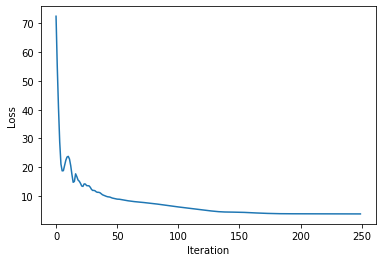

In [14]:
plt.plot(history.history['loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Results

In [15]:
parameter_values = model.predict([circuit_tensor, cost_operator_tensor, initial_parameters])[0]
print(f"Parameter values:\n {parameter_values}")

Parameter values:
 [[-0.04868803  0.20590317  0.06460886  0.28169897 -0.03694837  0.24002461
  -0.03072548  0.2590001  -0.05264992  0.22055705 -0.11836664  0.21324684
  -0.14726925  0.1953961  -0.16310373  0.1944601  -0.15901619  0.15442789
  -0.20996742  0.12093506]]


In [16]:
samples_amount = 2**16
sample_layer = tfq.layers.Sample()
output = sample_layer(circuit_tensor, 
                      symbol_names=qaoa_tsp.parameters, 
                      symbol_values=parameter_values, 
                      repetitions=samples_amount)

In [17]:
from collections import Counter

results = output.numpy()[0].astype(str).tolist()
results_to_display = [''.join(result) for result in results]
correct_results = ("0001100001000010","0010010010000001","0100100000010010","1000000100100100","1000010000100001","0100001000011000","0001001001001000","0010000110000100","0100000110000010","0010100000010100","0001010000101000","0001100000100100","1000000101000010","1000001001000001","0100001010000001", "0100000100101000", "0010010000011000", "0100100000100001", "1000001000010100", "0001001010000100", "0001010010000010","0010000101001000", "1000010000010010", "0010100001000001")
counts = Counter(results_to_display)

correct_results_count = sum(counts[result] for result in correct_results)
print(f'Correct results: {round(correct_results_count / samples_amount * 100,2)}% \n')

print(f'bin \t\t\t\t occurences \t correct?')
for row in counts.most_common():
    is_correct = row[0] in (correct_results)
    print(f"{row[0][0:4]} \t {row[0][4:8]} \t {row[0][8:12]} \t {row[0][12:]} \t {row[1]} \t\t {is_correct}")

Correct results: 92.79% 

bin 				 occurences 	 correct?
0001 	 0100 	 0010 	 1000 	 2732 		 True
0001 	 1000 	 0010 	 0100 	 2720 		 True
0100 	 0001 	 0010 	 1000 	 2710 		 True
0010 	 1000 	 0001 	 0100 	 2683 		 True
1000 	 0010 	 0100 	 0001 	 2681 		 True
0001 	 0010 	 1000 	 0100 	 2679 		 True
0100 	 0010 	 1000 	 0001 	 2678 		 True
0010 	 0001 	 0100 	 1000 	 2672 		 True
0010 	 1000 	 0100 	 0001 	 2671 		 True
1000 	 0100 	 0001 	 0010 	 2648 		 True
0100 	 0001 	 1000 	 0010 	 2646 		 True
0001 	 0100 	 1000 	 0010 	 2644 		 True
1000 	 0010 	 0001 	 0100 	 2640 		 True
0100 	 1000 	 0010 	 0001 	 2625 		 True
0010 	 0100 	 0001 	 1000 	 2616 		 True
1000 	 0001 	 0100 	 0010 	 2611 		 True
0100 	 1000 	 0001 	 0010 	 2344 		 True
1000 	 0100 	 0010 	 0001 	 2334 		 True
0010 	 0100 	 1000 	 0001 	 2270 		 True
0001 	 0010 	 0100 	 1000 	 2264 		 True
0100 	 0010 	 0001 	 1000 	 2257 		 True
0010 	 0001 	 1000 	 0100 	 2254 		 True
1000 	 0001 	 0010 	 0100 	 2218 		 True
